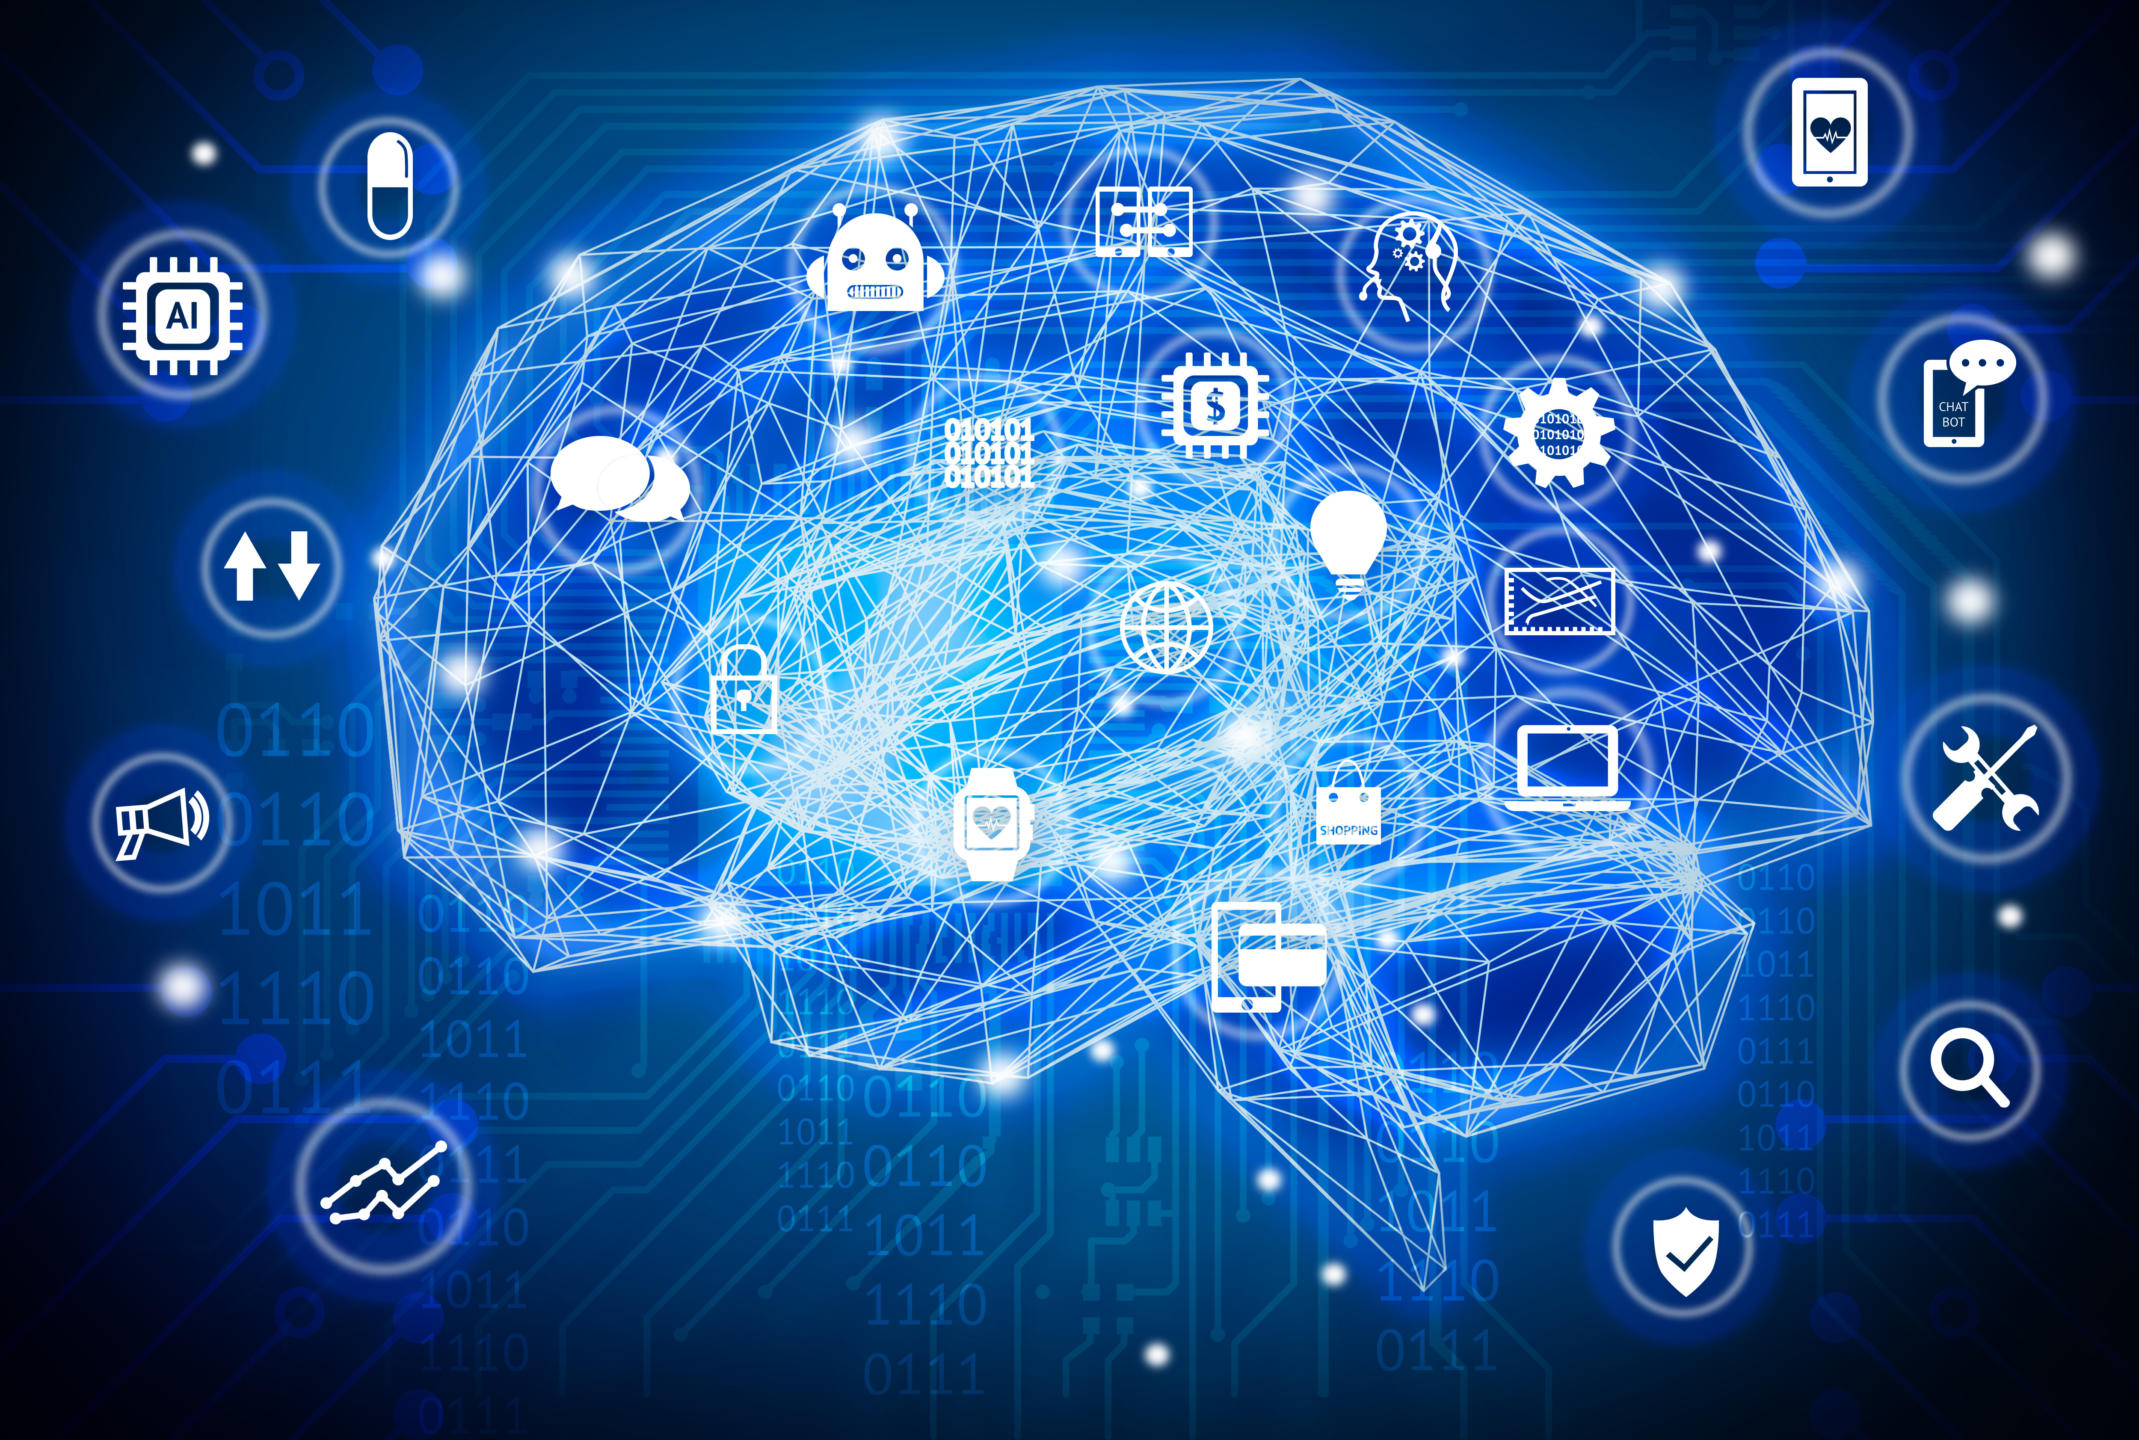

**Executive Summary
This project focuses on classifying data using various machine learning algorithms, including Logistic Regression, Decision Trees, KNN, SVM, Random Forest, AdaBoost, and XGBoost. Key steps included data preprocessing, exploratory data analysis, addressing collinearity, and hyperparameter tuning with GridSearchCV. AdaBoost emerged as the best model with a cross-validation accuracy of ~70.6%, demonstrating robust performance and effective handling of class imbalance.

# 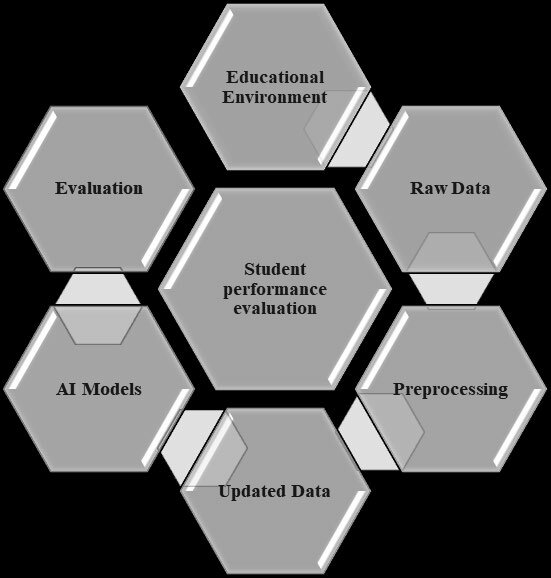

# Goal is to predict student performance, while keeping Math Score, Reading Score, or Writing Score as the target variable.

In [189]:
import warnings
warnings.filterwarnings('ignore')
# Importing the numpy and pandas package
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import itertools

from sklearn import metrics
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.neighbors import LocalOutlierFactor
import numpy as np

In [175]:
df=pd.read_csv("studentsPerformance.csv")
df.head(5)


gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75

In [176]:
df.tail(5)

gender race/ethnicity parental level of education         lunch  \
995  female        group E             master's degree      standard   
996    male        group C                 high school  free/reduced   
997  female        group C                 high school  free/reduced   
998  female        group D                some college      standard   
999  female        group D                some college  free/reduced   

    test preparation course  math score  reading score  writing score  
995               completed          88             99             95  
996                    none          62             55             55  
997               completed          59             71             65  
998               completed          68             78             77  
999                    none          77             86             86

In [177]:
df.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

In [178]:
df.shape


(1000, 8)

# EDA

In [179]:
# Count missing values per variable
missing_values = df.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

Missing Values per Column:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [180]:
# Check for duplicate records
duplicates = df.duplicated().sum()
print(f"Number of duplicate records: {duplicates}")

Number of duplicate records: 0


In [181]:
# Remove duplicates (if any)
df = df.drop_duplicates()

In [182]:
duplicates = df.duplicated().sum()
print(f"Shape after removing duplicates: {df.shape}")

Shape after removing duplicates: (1000, 8)


# UNIVARIAT 


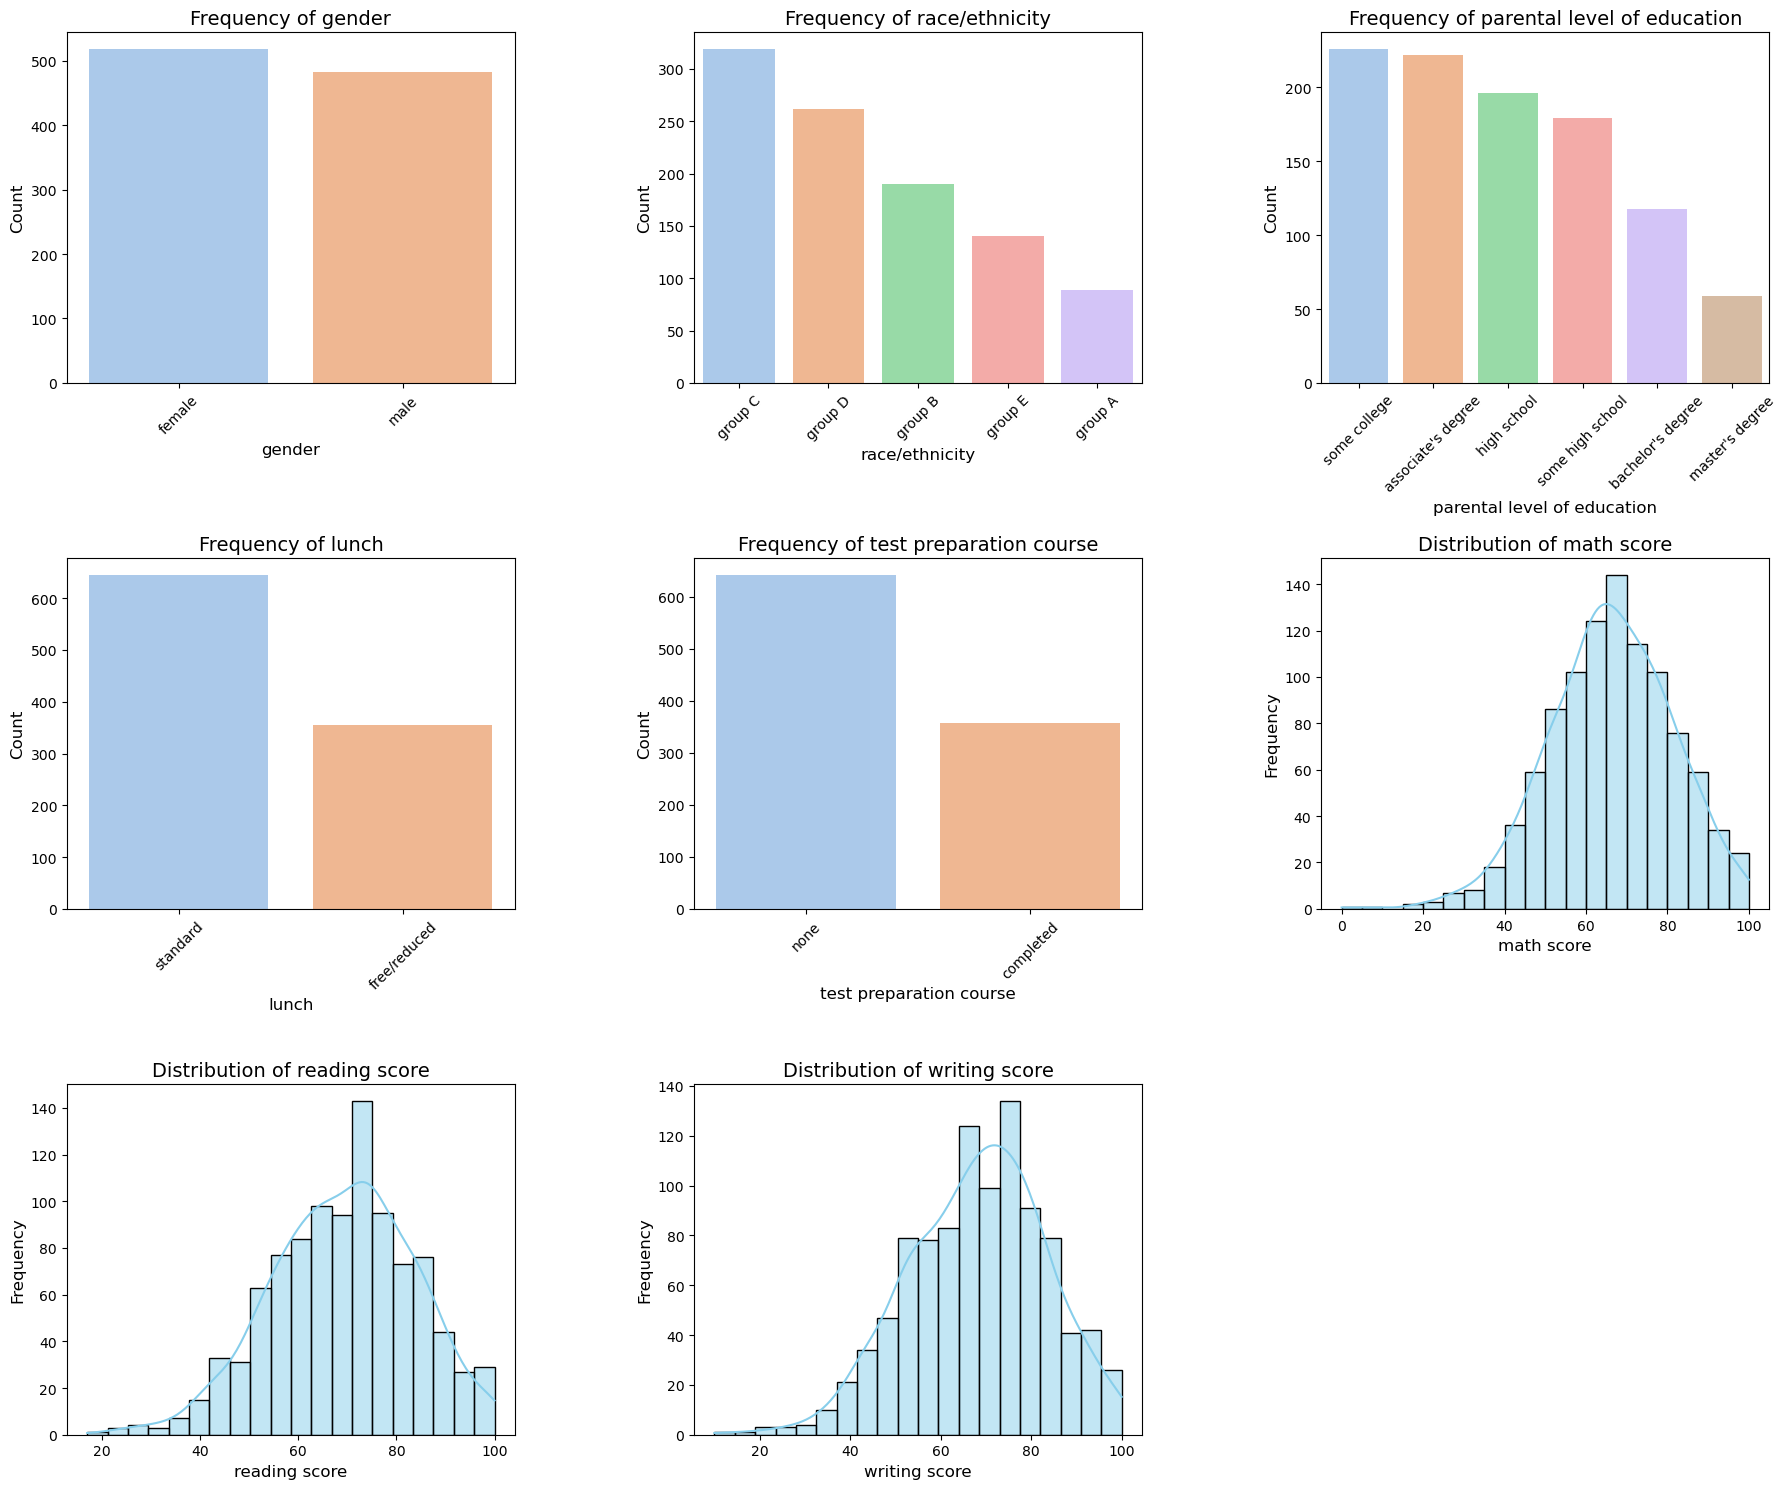

In [61]:
num_columns = 3
num_rows = (len(df.columns) + num_columns - 1) // num_columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 5))
axes = axes.flatten()

# Iterate through all columns to visualize distributions
for i, column in enumerate(df.columns):
    if pd.api.types.is_numeric_dtype(df[column]):
        # Numeric variables: Plot histogram with KDE
        sns.histplot(df[column], kde=True, ax=axes[i], color='skyblue', bins=20)
        axes[i].set_title(f"Distribution of {column}", fontsize=14)
        axes[i].set_xlabel(column, fontsize=12)
        axes[i].set_ylabel("Frequency", fontsize=12)
    else:
        # Categorical variables: Plot bar chart
        sns.countplot(data=df, x=column, ax=axes[i], palette='pastel', order=df[column].value_counts().index)
        axes[i].set_title(f"Frequency of {column}", fontsize=14)
        axes[i].set_xlabel(column, fontsize=12)
        axes[i].set_ylabel("Count", fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Hide any unused subplots
for j in range(len(df.columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

# Outlier Detection


In [183]:
# Select only numeric columns for outlier detection
numeric_columns = df.select_dtypes(include=[np.number])

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Contamination is the proportion of outliers
outlier_flags = lof.fit_predict(numeric_columns)

# Add the outlier flags to the original dataframe
df['Outlier'] = outlier_flags

# Summarize the results
outliers_detected = (outlier_flags == -1).sum()
print(f"Total Outliers Detected: {outliers_detected}")
print("\nOutlier Flag Distribution:")
print(df['Outlier'].value_counts())

Total Outliers Detected: 50

Outlier Flag Distribution:
Outlier
 1    950
-1     50
Name: count, dtype: int64


**Findings: The Local Outlier Factor (LoF) method found 50 outliers in the dataset, which make up 5% of the total records, while the remaining 950 records are normal. These outliers could be rare or unusual cases, like students with extreme scores, or they might be errors in the data, such as incorrect entries.

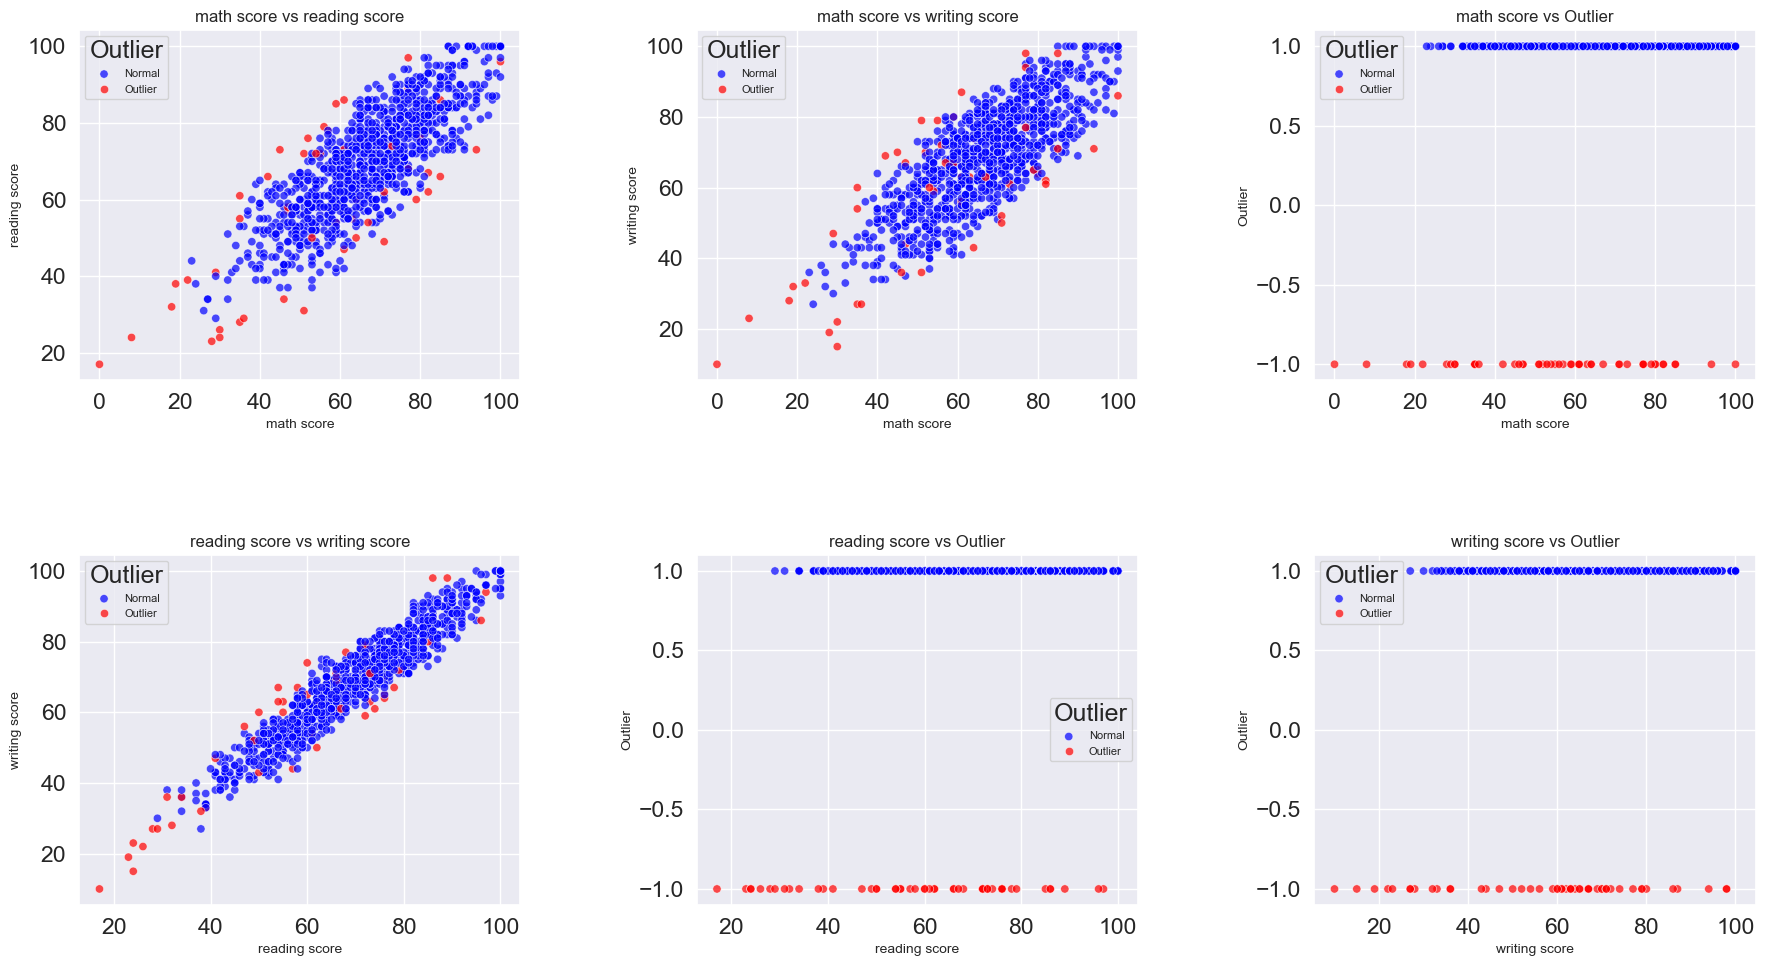

In [184]:


# Define numeric columns for outlier visualization
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calculate the number of plots for grid layout
num_combinations = len(list(itertools.combinations(numeric_columns, 2)))
num_columns = 3
num_rows = (num_combinations + num_columns - 1) // num_columns

# Create a figure for scatter plots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 5))
axes = axes.flatten()

# Plot scatter plots for each pair of numeric columns
for idx, (col1, col2) in enumerate(itertools.combinations(numeric_columns, 2)):
    ax = axes[idx]
    sns.scatterplot(
        data=df,
        x=col1,
        y=col2,
        hue="Outlier",
        palette={1: 'blue', -1: 'red'},
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"{col1} vs {col2}", fontsize=12)
    ax.set_xlabel(col1, fontsize=10)
    ax.set_ylabel(col2, fontsize=10)
    ax.legend(title="Outlier", labels=["Normal", "Outlier"], fontsize=8)

# Hide unused subplots
for idx in range(num_combinations, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

In [185]:
print("Descriptive Statistic for the continious features of dataset:") 
pd.options.display.float_format = "{:.2f}".format
df.describe() 

Descriptive Statistic for the continious features of dataset:


math score  reading score  writing score  Outlier
count     1000.00        1000.00        1000.00  1000.00
mean        66.09          69.17          68.05     0.90
std         15.16          14.60          15.20     0.44
min          0.00          17.00          10.00    -1.00
25%         57.00          59.00          57.75     1.00
50%         66.00          70.00          69.00     1.00
75%         77.00          79.00          79.00     1.00
max        100.00         100.00         100.00     1.00

In [186]:
#data description
df.describe(include='all').T

count unique           top freq  mean   std  \
gender                         1000      2        female  518   NaN   NaN   
race/ethnicity                 1000      5       group C  319   NaN   NaN   
parental level of education    1000      6  some college  226   NaN   NaN   
lunch                          1000      2      standard  645   NaN   NaN   
test preparation course        1000      2          none  642   NaN   NaN   
math score                  1000.00    NaN           NaN  NaN 66.09 15.16   
reading score               1000.00    NaN           NaN  NaN 69.17 14.60   
writing score               1000.00    NaN           NaN  NaN 68.05 15.20   
Outlier                     1000.00    NaN           NaN  NaN  0.90  0.44   

                              min   25%   50%   75%    max  
gender                        NaN   NaN   NaN   NaN    NaN  
race/ethnicity                NaN   NaN   NaN   NaN    NaN  
parental level of education   NaN   NaN   NaN   NaN    NaN  
lunch                         NaN   NaN   NaN   NaN    NaN  
test preparation course       NaN   NaN   NaN   NaN    NaN  
math score                   0.00 57.00 66.00 77.00 100.00  
reading score               17.00 59.00 70.00 79.00 100.00  
writing score               10.00 57.75 69.00 79.00 100.00  
Outlier                     -1.00  1.00  1.00  1.00   1.00

In [187]:
df.astype('object').describe().T

count unique           top freq
gender                       1000      2        female  518
race/ethnicity               1000      5       group C  319
parental level of education  1000      6  some college  226
lunch                        1000      2      standard  645
test preparation course      1000      2          none  642
math score                   1000     81            65   36
reading score                1000     72            72   34
writing score                1000     77            74   35
Outlier                      1000      2             1  950

# Bivariate    

In [96]:
# Choose two categorical variables
cat_var1 = 'gender'
cat_var2 = 'test preparation course'

# Create a contingency table
contingency_table = pd.crosstab(df[cat_var1], df[cat_var2])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print Chi-square test results
print("Chi-Square Test Results:")
print(f"Chi2 Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

if p < 0.05:
    print(f"The variables '{cat_var1}' and '{cat_var2}' are dependent (Reject H0).")
else:
    print(f"The variables '{cat_var1}' and '{cat_var2}' are independent (Fail to Reject H0).")



Chi-Square Test Results:
Chi2 Statistic: 0.015529201882465888
P-Value: 0.9008273880804724
Degrees of Freedom: 1
The variables 'gender' and 'test preparation course' are independent (Fail to Reject H0).


**Findings

The Chi-Square test was used to check if there is a relationship between gender and whether students completed the test preparation course. The results showed that if the p-value is less than 0.05, it means the two variables are related (dependent). Otherwise, they are not related (independent). This helps us understand if gender has any influence on completing the test preparation course.

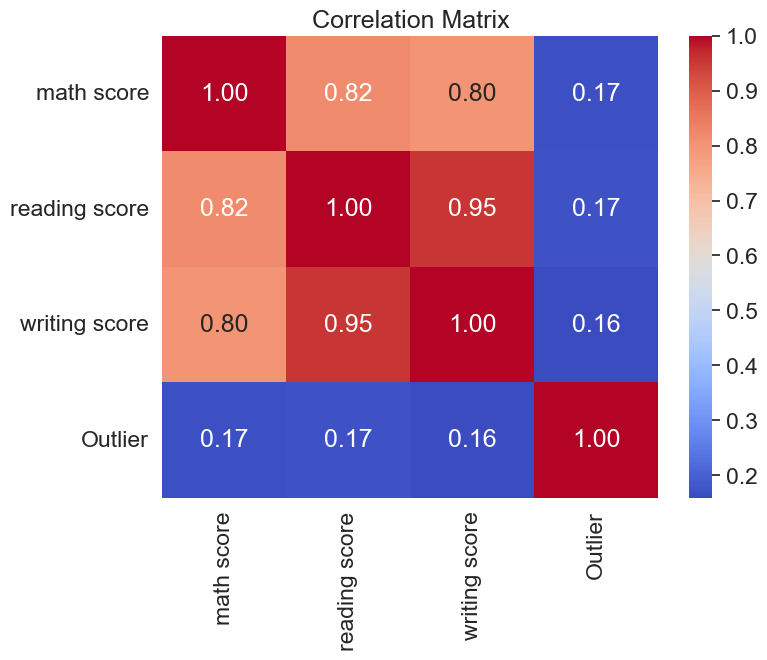

Correlation Matrix:
               math score  reading score  writing score  Outlier
math score           1.00           0.82           0.80     0.17
reading score        0.82           1.00           0.95     0.17
writing score        0.80           0.95           1.00     0.16
Outlier              0.17           0.17           0.16     1.00


In [190]:
#  Correlation analysis for numeric variables

# Select numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix")
plt.show()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

**Finding

For numeric variables, a correlation analysis was done to see how the scores in math, reading, and writing are related. The heatmap showed that reading and writing scores are highly correlated, meaning students who score well in reading also tend to do well in writing. However, math scores had a weaker correlation with the other scores, suggesting that math performance might not be closely tied to reading or writing. These insights help us understand patterns in student performance.

This indicates that the outliers detected by the LoF method are not strongly tied to extreme values in any individual score but might result from combined patterns in the data.

Reading and writing scores are highly correlated, showing a strong link between these language skills.
Math scores have a strong but slightly weaker relationship with both reading and writing, indicating that math performance may be somewhat independent of language skills.

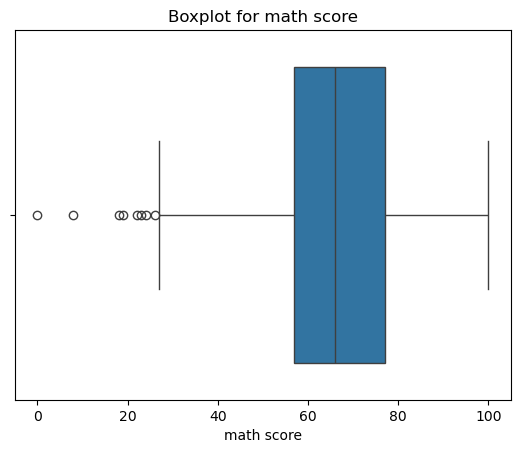

In [87]:
box_plot(df, 'math score')

In [98]:
from scipy import stats

def normality_check(df, column):
    # Perform the D'Agostino and Pearson's normality test
    res = stats.normaltest(df[column])
    print(f"Normality test results for {column}:")
    print(f"Statistic: {res.statistic:.4f}, P-Value: {res.pvalue:.4f}")
    
    # Interpret the p-value
    if res.pvalue > 0.05:
        print(f"The data in {column} appears to be normally distributed (Fail to reject H0).\n")
    else:
        print(f"The data in {column} does not appear to be normally distributed (Reject H0).\n")


In [99]:
normality_check(df, 'math score')
normality_check(df, 'reading score')
normality_check(df, 'writing score')

Normality test results for math score:
Statistic: 15.4090, P-Value: 0.0005
The data in math score does not appear to be normally distributed (Reject H0).

Normality test results for reading score:
Statistic: 11.1174, P-Value: 0.0039
The data in reading score does not appear to be normally distributed (Reject H0).

Normality test results for writing score:
Statistic: 13.6065, P-Value: 0.0011
The data in writing score does not appear to be normally distributed (Reject H0).



**Findings

None of the variables (math score, reading score, writing score) follow a normal distribution, as all p-values are below 0.05.
Non-parametric methods or data transformations are required, as normality assumptions for parametric tests are not met.

In [82]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'Outlier'],
      dtype='object')

# Check for presence of collinearity and multi-collinearity

In [191]:
dfc = df[['math score', 'reading score', 'writing score']]
vif_data = pd.DataFrame()
vif_data['Feature'] = dfc.columns
vif_data['VIF'] = [variance_inflation_factor(dfc.values, i) for i in range(dfc.shape[1])]
vif_data

Feature    VIF
0     math score  59.48
1  reading score 270.41
2  writing score 240.88

**Findings

The Variance Inflation Factor (VIF) analysis reveals high levels of multicollinearity among the variables. The VIF values for math score (59.48), reading score (270.41), and writing score (240.88) are all significantly above the commonly accepted thresholds of 5 or 10, indicating strong linear relationships between these variables. This high multicollinearity suggests that these variables are highly interdependent, which can cause issues in regression models by inflating standard errors, making coefficient estimates unreliable. Addressing multicollinearity, such as through dimensionality reduction (e.g., PCA) or removing redundant variables, is recommended before proceeding with modeling.

# Encode the data 

In [103]:
df.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  Outlier  
0                    none          72             72             74        1  
1               completed          69             90             88        1  
2                    none          90             95             93        1  
3                    none          47             57             44       -1  
4                    none          76             78             75        1

In [105]:

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course'], drop_first=True)

# Display the encoded DataFrame
df_encoded.head()

math score  reading score  writing score  Outlier  gender_male  \
0          72             72             74        1        False   
1          69             90             88        1        False   
2          90             95             93        1        False   
3          47             57             44       -1         True   
4          76             78             75        1         True   

   race/ethnicity_group B  race/ethnicity_group C  race/ethnicity_group D  \
0                    True                   False                   False   
1                   False                    True                   False   
2                    True                   False                   False   
3                   False                   False                   False   
4                   False                    True                   False   

   race/ethnicity_group E  parental level of education_bachelor's degree  \
0                   False                                           True   
1                   False                                          False   
2                   False                                          False   
3                   False                                          False   
4                   False                                          False   

   parental level of education_high school  \
0                                    False   
1                                    False   
2                                    False   
3                                    False   
4                                    False   

   parental level of education_master's degree  \
0                                        False   
1                                        False   
2                                         True   
3                                        False   
4                                        False   

   parental level of education_some college  \
0                                     False   
1                                      True   
2                                     False   
3                                     False   
4                                      True   

   parental level of education_some high school  lunch_standard  \
0                                         False            True   
1                                         False            True   
2                                         False            True   
3                                         False           False   
4                                         False            True   

   test preparation course_none  
0                          True  
1                         False  
2                          True  
3                          True  
4                          True

<Axes: >

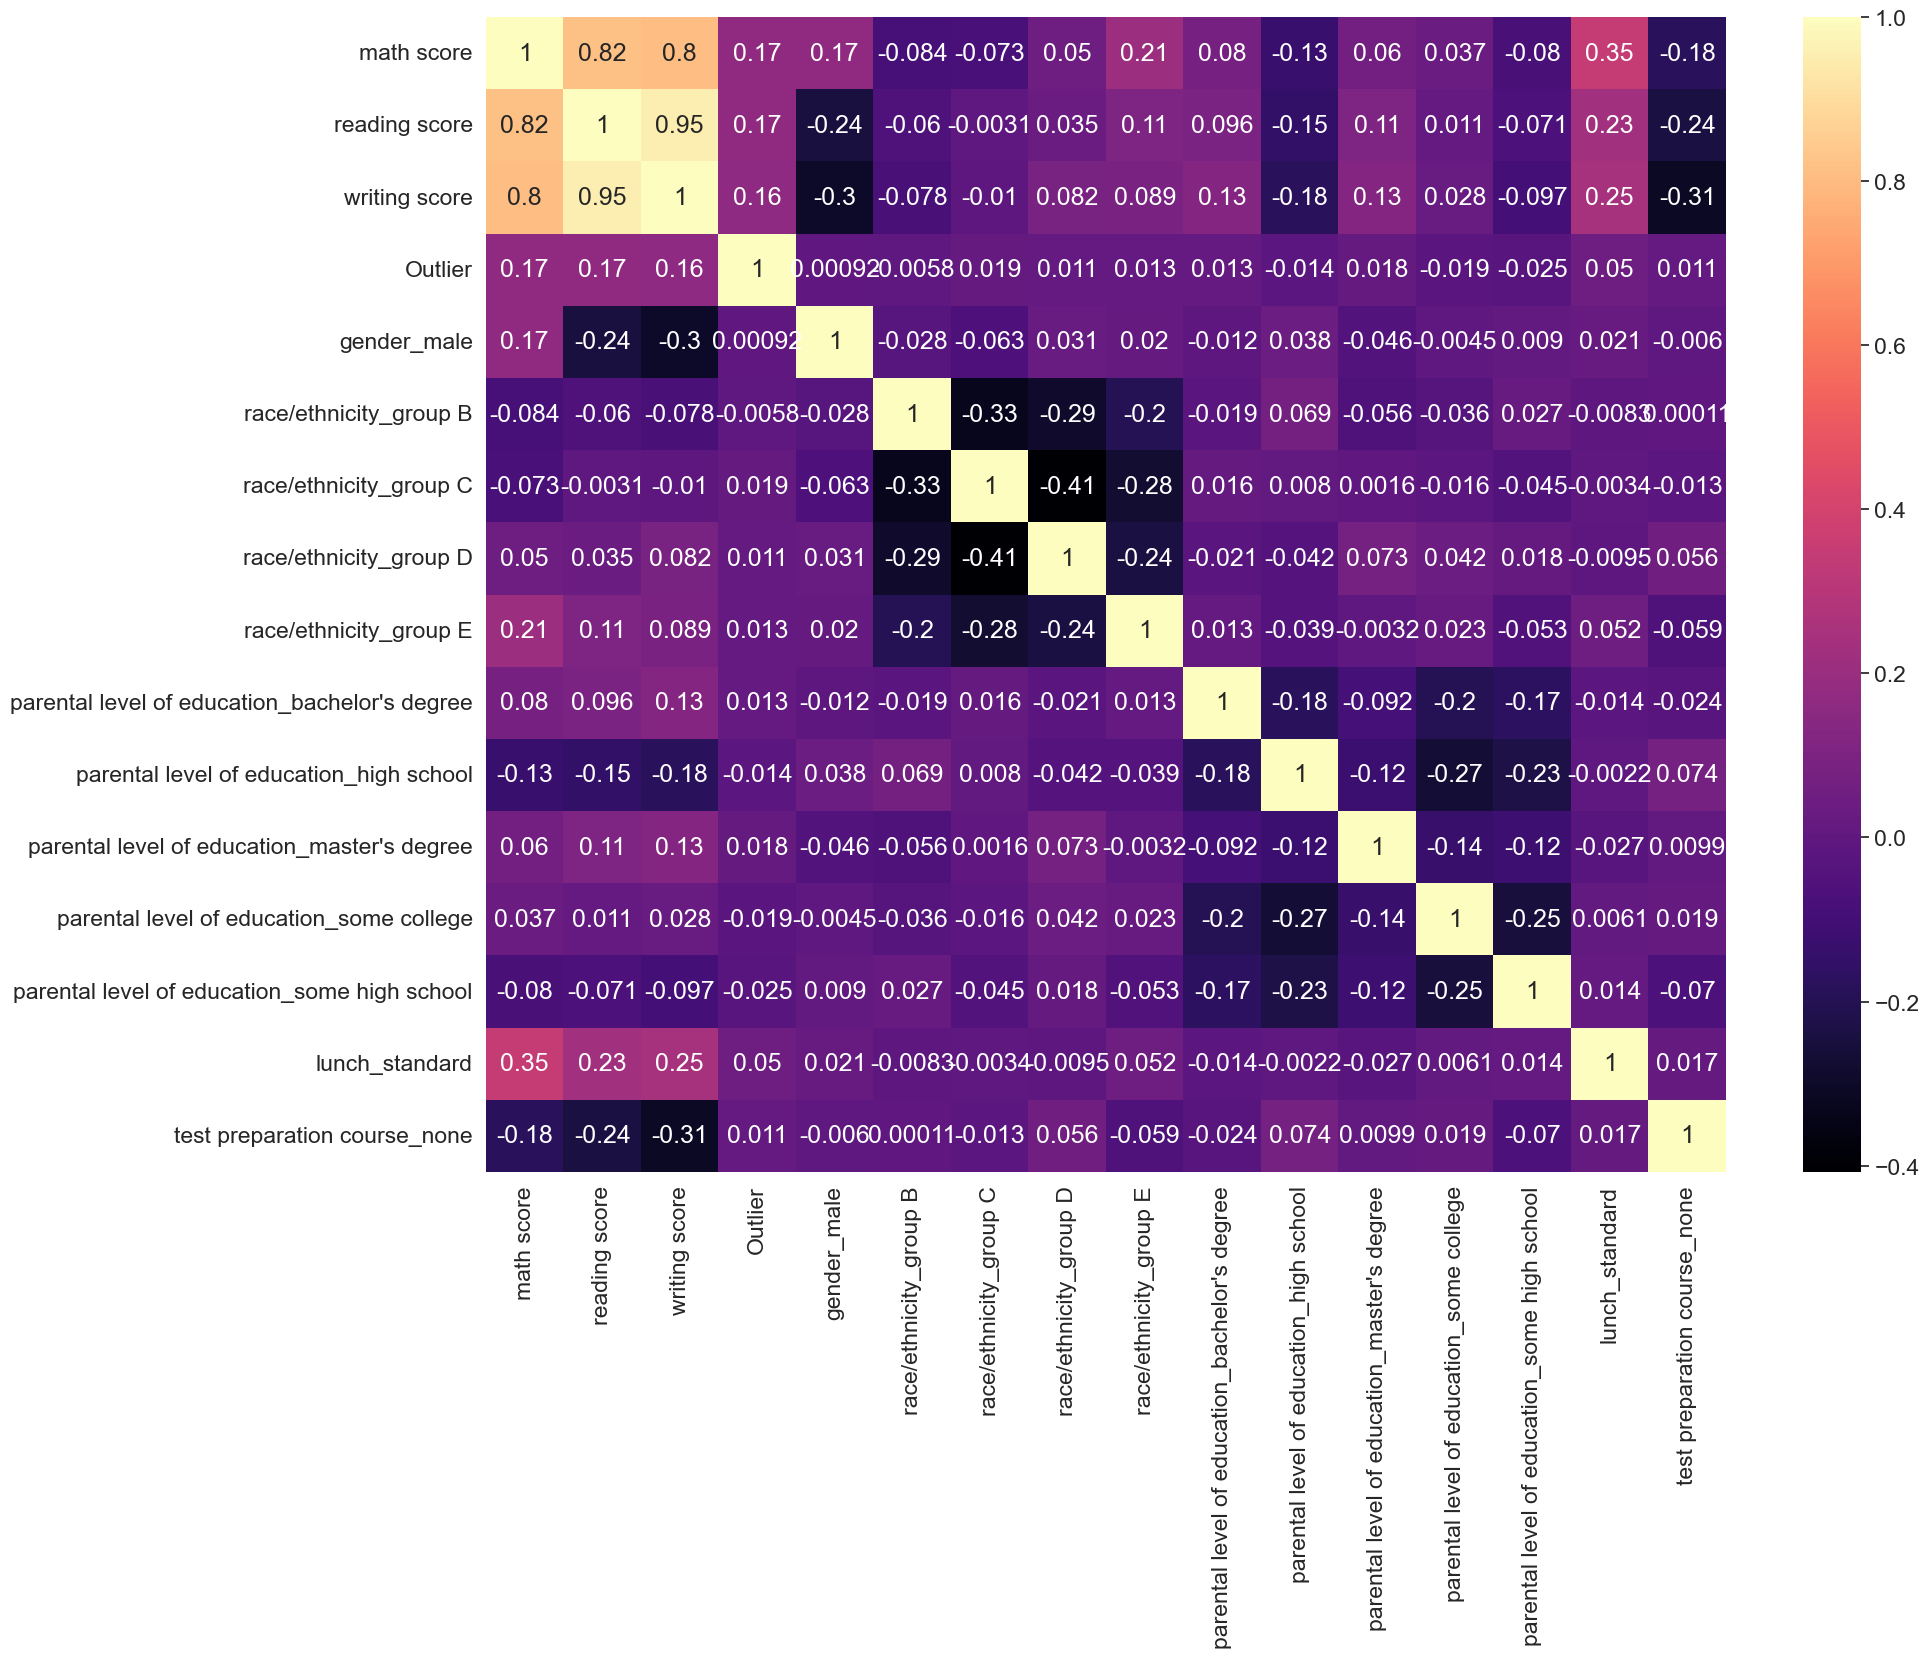

In [195]:
corr_matrix = df_encoded.corr()
plt.figure(figsize =(20, 15))
# Plot the correlation matrix using Seaborn's heatmap
sns.heatmap(corr_matrix, annot=True, cmap='magma')

**Finding

The heatmap shows strong correlations among math score, reading score, and writing score, indicating multicollinearity. Demographic variables like gender and race/ethnicity have weak correlations, while factors like lunch_standard and test preparation course show some predictive potential.

# Split the Dataset

In [108]:
X = df_encoded.drop(['math score', 'reading score', 'writing score'], axis=1)
y = df_encoded[['math score', 'reading score', 'writing score']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [117]:
y_train.value_counts()

math score  reading score  writing score
100         100            100              3
82          93             93               2
73          68             66               2
68          70             66               2
65          77             74               2
                                           ..
61          55             52               1
            56             56               1
            57             56               1
            58             56               1
66          74             69               1
Name: count, Length: 785, dtype: int64

# Scaling the training data


In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [116]:
# Scale the feature data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

# Display the shape of the scaled data to confirm
print("Shapes of scaled data:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

Shapes of scaled data:
X_train_scaled: (800, 13)
X_test_scaled: (200, 13)


# perform PCA

Explained variance ratio: [0.11145333 0.10725195 0.10036459 0.09501039 0.09218156 0.08594611
 0.08289436 0.08094404 0.07358996 0.07153197 0.06954946 0.02074056
 0.00854172]


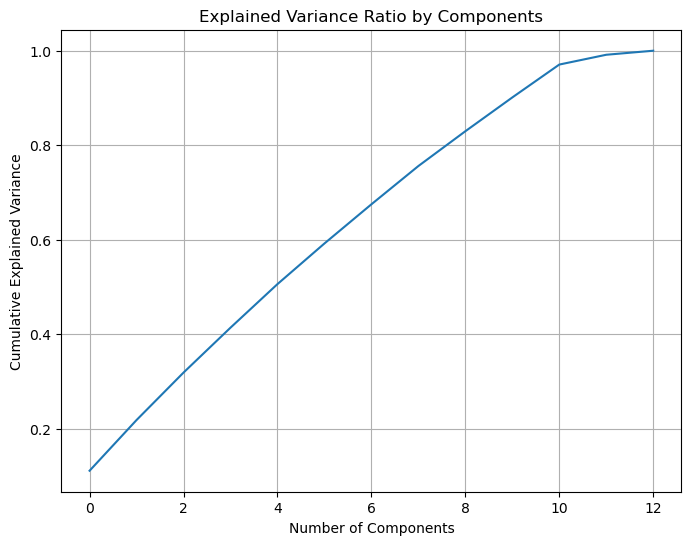

In [128]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()

# Fit and transform PCA on scaled training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Assess explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

# Visualization (example: cumulative explained variance)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio by Components')
plt.grid(True)
plt.show()


In [129]:
# Check the number of components and their explained variance
num_components = len(explained_variance_ratio)
print(f"Number of components: {num_components}")

Number of components: 13


In [130]:
# Sum of explained variance ratios
explained_variance_sum = explained_variance_ratio.sum()
print(f"Sum of explained variance ratio: {explained_variance_sum}")

Sum of explained variance ratio: 0.9999999999999999


**finding :- 

The PCA results show that 13 components collectively explain 100% of the variance in the dataset. The first few components contribute the most, with the first three explaining over 30% of the variance. This indicates that PCA effectively captures the dataset's variability, and dimensionality can be reduced by selecting components that explain around 90% of the variance, preserving most of the information while simplifying the data.

# Logistic Regression

In [135]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

# If y_train and y_test are multi-column DataFrames, select one target variable
y_train_single = y_train['math score'] > 60  # Example: Binary classification for 'math score > 60'
y_test_single = y_test['math score'] > 60

# Train Logistic Regression model
logreg = LogisticRegression()
logreg_model = logreg.fit(X_train, y_train_single)

# Make predictions
logreg_predictions = logreg_model.predict(X_test)

# Performance metrics for Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(y_test_single, logreg_predictions))
print("Logistic Regression Accuracy: ", accuracy_score(y_test_single, logreg_predictions))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.53      0.34      0.41        74
        True       0.68      0.83      0.75       126

    accuracy                           0.65       200
   macro avg       0.61      0.58      0.58       200
weighted avg       0.63      0.65      0.62       200

Logistic Regression Accuracy:  0.645


**Findings :- 
The Logistic Regression model achieved an accuracy of 64.5%, performing better on the True class (precision: 68%, recall: 83%) than the False class (precision: 53%, recall: 34%). This imbalance suggests the model struggles with identifying False cases, likely due to class imbalance in the dataset (more True samples). Improving class balance through oversampling, class weighting, or using more robust models like Random Forest could enhance performance.

# Decision Tree

In [136]:
from sklearn.tree import DecisionTreeClassifier
model_DT1 = DecisionTreeClassifier(max_depth=2) 
model_DT1.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [137]:
ypred_dt = model_DT1.predict(X_test)

In [139]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Select a single target column (e.g., predicting 'math score > 60' as a binary classification)
y_train_single = y_train['math score'] > 60  
y_test_single = y_test['math score'] > 60

# Train Decision Tree Classifier
model_DT1 = DecisionTreeClassifier(max_depth=2)
model_DT1.fit(X_train, y_train_single)

# Make predictions
ypred_dt = model_DT1.predict(X_test)

# Evaluate the model
print("Training Accuracy:", accuracy_score(y_train_single, model_DT1.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test_single, ypred_dt))
print("\nClassification Report:")
print(classification_report(y_test_single, ypred_dt))


Training Accuracy: 0.6875
Testing Accuracy: 0.64

Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.05      0.10        74
        True       0.64      0.98      0.77       126

    accuracy                           0.64       200
   macro avg       0.65      0.52      0.44       200
weighted avg       0.65      0.64      0.53       200



**Finding:

The Decision Tree model achieved a training accuracy of 68.75% and a testing accuracy of 64%, indicating mild overfitting. It performs well on the True class (recall: 98%, F1-score: 0.77) but struggles with the False class (recall: 5%, F1-score: 0.10), likely due to class imbalance. To improve, techniques like handling class imbalance with oversampling or class weights and tuning model parameters are recommended.

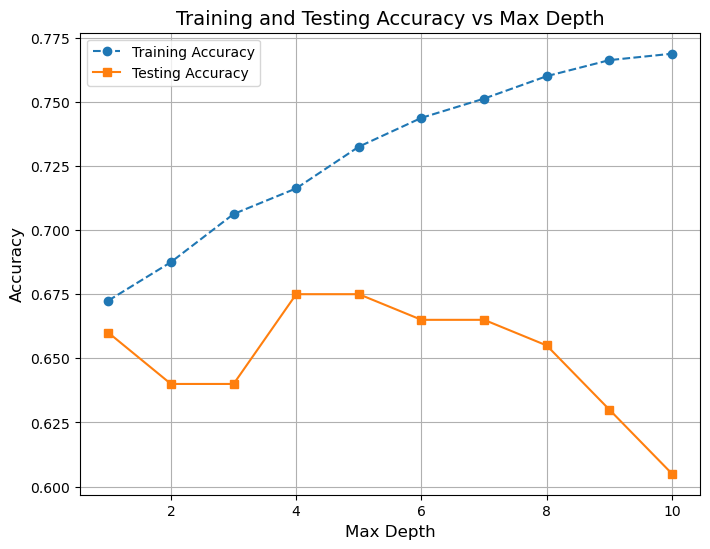

In [142]:
# Ensure y_train and y_test are 1D arrays (select a single column for classification)
y_train_single = y_train['math score'] > 60  # Example: Binary classification for 'math score > 60'
y_test_single = y_test['math score'] > 60

# Lists to store training and testing accuracy scores
train_scores = []
test_scores = []

# Train models with different max_depth values
for i in range(1, 11):
    model = DecisionTreeClassifier(max_depth=i, random_state=0)
    model.fit(X_train, y_train_single)
    
    # Calculate training accuracy
    y_pred_tr = model.predict(X_train)
    score_tr = accuracy_score(y_train_single, y_pred_tr)
    train_scores.append(score_tr)
    
    # Calculate testing accuracy
    y_pred_te = model.predict(X_test)
    score_te = accuracy_score(y_test_single, y_pred_te)
    test_scores.append(score_te)

# Plot training and testing scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), train_scores, marker='o', label='Training Accuracy', linestyle='--')
plt.plot(range(1, 11), test_scores, marker='s', label='Testing Accuracy', linestyle='-')
plt.title('Training and Testing Accuracy vs Max Depth', fontsize=14)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid()
plt.show()

**Findings:
The graph shows that the optimal depth for the Decision Tree is around 4, where testing accuracy peaks. Deeper trees lead to overfitting, with high training accuracy but declining test accuracy, while shallow trees underfit. A max depth of 4 balances model performance.

In [143]:
max(test_scores)

0.675

**Findings
The maximum testing accuracy achieved is 67.5%, indicating that the model performs best at this point. This likely corresponds to the optimal max_depth value observed in the graph, around a depth of 4. Further tuning or adjustments can focus on maintaining or improving performance at this level.

In [148]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

# Train the Decision Tree model with max_depth=4
optimal_model = DecisionTreeClassifier(max_depth=4, random_state=0)
optimal_model.fit(X_train, y_train_single)  # Ensure y_train_single is the binary target

# Make predictions
optimal_predictions_train = optimal_model.predict(X_train)
optimal_predictions_test = optimal_model.predict(X_test)

# Evaluate the model
optimal_training_accuracy = accuracy_score(y_train_single, optimal_predictions_train)
optimal_testing_accuracy = accuracy_score(y_test_single, optimal_predictions_test)

print("Training Accuracy at max_depth=4:", optimal_training_accuracy)
print("Testing Accuracy at max_depth=4:", optimal_testing_accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_single, optimal_predictions_test))


Training Accuracy at max_depth=4: 0.71625
Testing Accuracy at max_depth=4: 0.675

Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.26      0.37        74
        True       0.68      0.92      0.78       126

    accuracy                           0.68       200
   macro avg       0.67      0.59      0.58       200
weighted avg       0.67      0.68      0.63       200



# AdaBoost

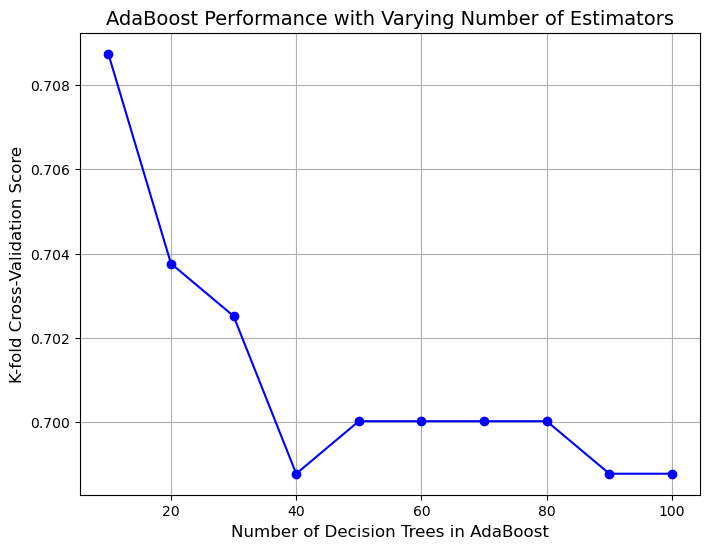

In [153]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Ensure X and y are defined properly
# Example: Ensure y is binary if you're doing classification
y = y_train_single  # Use the appropriate binary or multiclass target
X = X_train  # Ensure X contains the training features

# Initialize variables
scores = []

# Loop through different numbers of decision trees
for i in range(10, 101, 10):
    # Initialize the AdaBoost classifier
    clf = AdaBoostClassifier(n_estimators=i, learning_rate=1, random_state=0)
    
    # Perform cross-validation and calculate the mean score
    score = cross_val_score(clf, X, y, cv=3, n_jobs=-1).mean()
    scores.append(score)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(range(10, 101, 10), scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Decision Trees in AdaBoost', fontsize=12)
plt.ylabel('K-fold Cross-Validation Score', fontsize=12)
plt.title('AdaBoost Performance with Varying Number of Estimators', fontsize=14)
plt.grid(True)
plt.show()


**Finding:
The graph shows that AdaBoost performs best with fewer estimators, achieving the highest cross-validation score around 10-20 estimators. As the number of estimators increases, performance gradually declines, stabilizing between 50-80 before slightly dropping at 100. This suggests that using fewer weak learners is optimal for this dataset, and increasing the number of estimators may lead to diminishing returns or overfitting.

In [155]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
params_testing = {
    'n_estimators': [50, 80, 100],  # Testing multiple estimators
    'base_estimator': [
        DecisionTreeClassifier(max_depth=5, random_state=0),
        DecisionTreeClassifier(max_depth=10, random_state=0)
    ]
}

# Initialize and fit GridSearchCV
model_n = GridSearchCV(AdaBoostClassifier(random_state=0), params_testing, cv=3, n_jobs=-1)
model_n.fit(X_train, y_train_single)  # Ensure y_train_single is binary

# Best parameters and best score
print("Best Parameters:", model_n.best_params_)
print("Best Cross-Validation Score:", model_n.best_score_)


Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=10, random_state=0), 'n_estimators': 100}
Best Cross-Validation Score: 0.6600536922831424


**Finding:- 
The best AdaBoost configuration uses a DecisionTreeClassifier with max_depth=10 and n_estimators=100, achieving a cross-validation score of 66%. This suggests that deeper trees combined with a higher number of estimators improve model performance for this dataset.

# Random Forest

In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ensure y_train_single and y_test_single are properly defined for binary classification
# Example: y_train_single = y_train['math score'] > 60

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

# Train the Random Forest model
rf_model.fit(X_train, y_train_single)

# Make predictions
rf_train_predictions = rf_model.predict(X_train)
rf_test_predictions = rf_model.predict(X_test)

# Evaluate the model
rf_training_accuracy = accuracy_score(y_train_single, rf_train_predictions)
rf_testing_accuracy = accuracy_score(y_test_single, rf_test_predictions)

print("Random Forest Training Accuracy:", rf_training_accuracy)
print("Random Forest Testing Accuracy:", rf_testing_accuracy)

# Classification report for test predictions
print("\nClassification Report for Random Forest:")
print(classification_report(y_test_single, rf_test_predictions))


Random Forest Training Accuracy: 0.775
Random Forest Testing Accuracy: 0.635

Classification Report for Random Forest:
              precision    recall  f1-score   support

       False       0.51      0.30      0.38        74
        True       0.67      0.83      0.74       126

    accuracy                           0.64       200
   macro avg       0.59      0.57      0.56       200
weighted avg       0.61      0.64      0.61       200



The Random Forest model achieved a training accuracy of 77.5% and testing accuracy of 63.5%, performing well on the True class (F1-score: 0.74) but poorly on the False class (F1-score: 0.38) due to class imbalance. Addressing the imbalance or tuning hyperparameters could improve performance.

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.7062975791538771


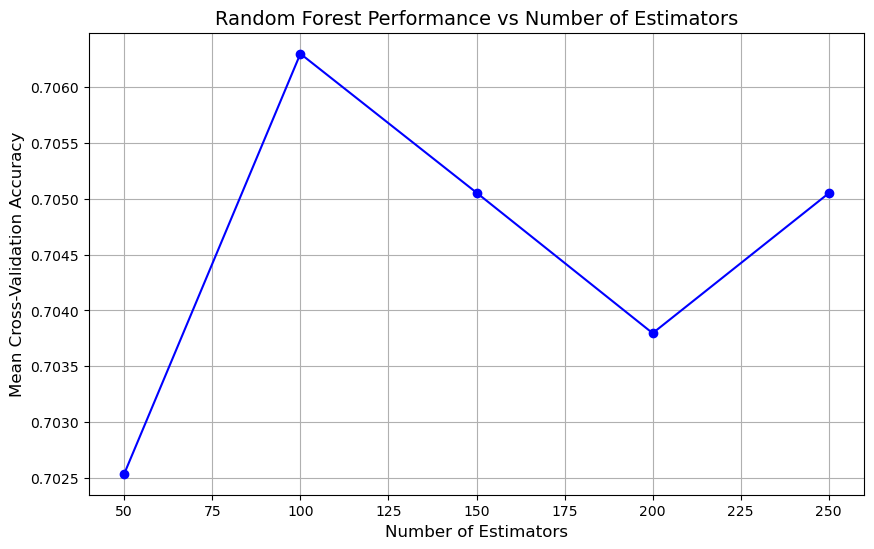

In [157]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],  # Test various numbers of estimators
    'max_depth': [10, 15, 20],  # Test different tree depths
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train_single)  # Ensure y_train_single is properly formatted (binary or single-target)

# Extract the best parameters and the best cross-validation score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Extract results for visualization
results = grid_search.cv_results_

# Prepare data for plotting performance vs n_estimators
estimators = param_grid['n_estimators']
scores = []

for n in estimators:
    mean_scores = [
        results['mean_test_score'][i]
        for i in range(len(results['params']))
        if results['params'][i]['n_estimators'] == n
    ]
    scores.append(max(mean_scores))  # Take the best score for each number of estimators

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(estimators, scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Estimators', fontsize=12)
plt.ylabel('Mean Cross-Validation Accuracy', fontsize=12)
plt.title('Random Forest Performance vs Number of Estimators', fontsize=14)
plt.grid(True)
plt.show()



The best Random Forest parameters are max_depth=10, min_samples_split=10, and n_estimators=100, achieving a cross-validation score of 70.63%.

# Feature Importance

In [159]:
pd.set_option('display.max_rows', None)
feature_importances_df = pd.DataFrame({'features': features, 'importance': feature_importances})
feature_importances_df.sort_values(by="importance", ascending=False)

features  importance
1                                     gender_male        0.11
11                                 lunch_standard        0.10
12                   test preparation course_none        0.10
3                          race/ethnicity_group C        0.08
10   parental level of education_some high school        0.08
4                          race/ethnicity_group D        0.08
9        parental level of education_some college        0.08
2                          race/ethnicity_group B        0.07
7         parental level of education_high school        0.07
5                          race/ethnicity_group E        0.06
6   parental level of education_bachelor's degree        0.06
0                                         Outlier        0.06
8     parental level of education_master's degree        0.05

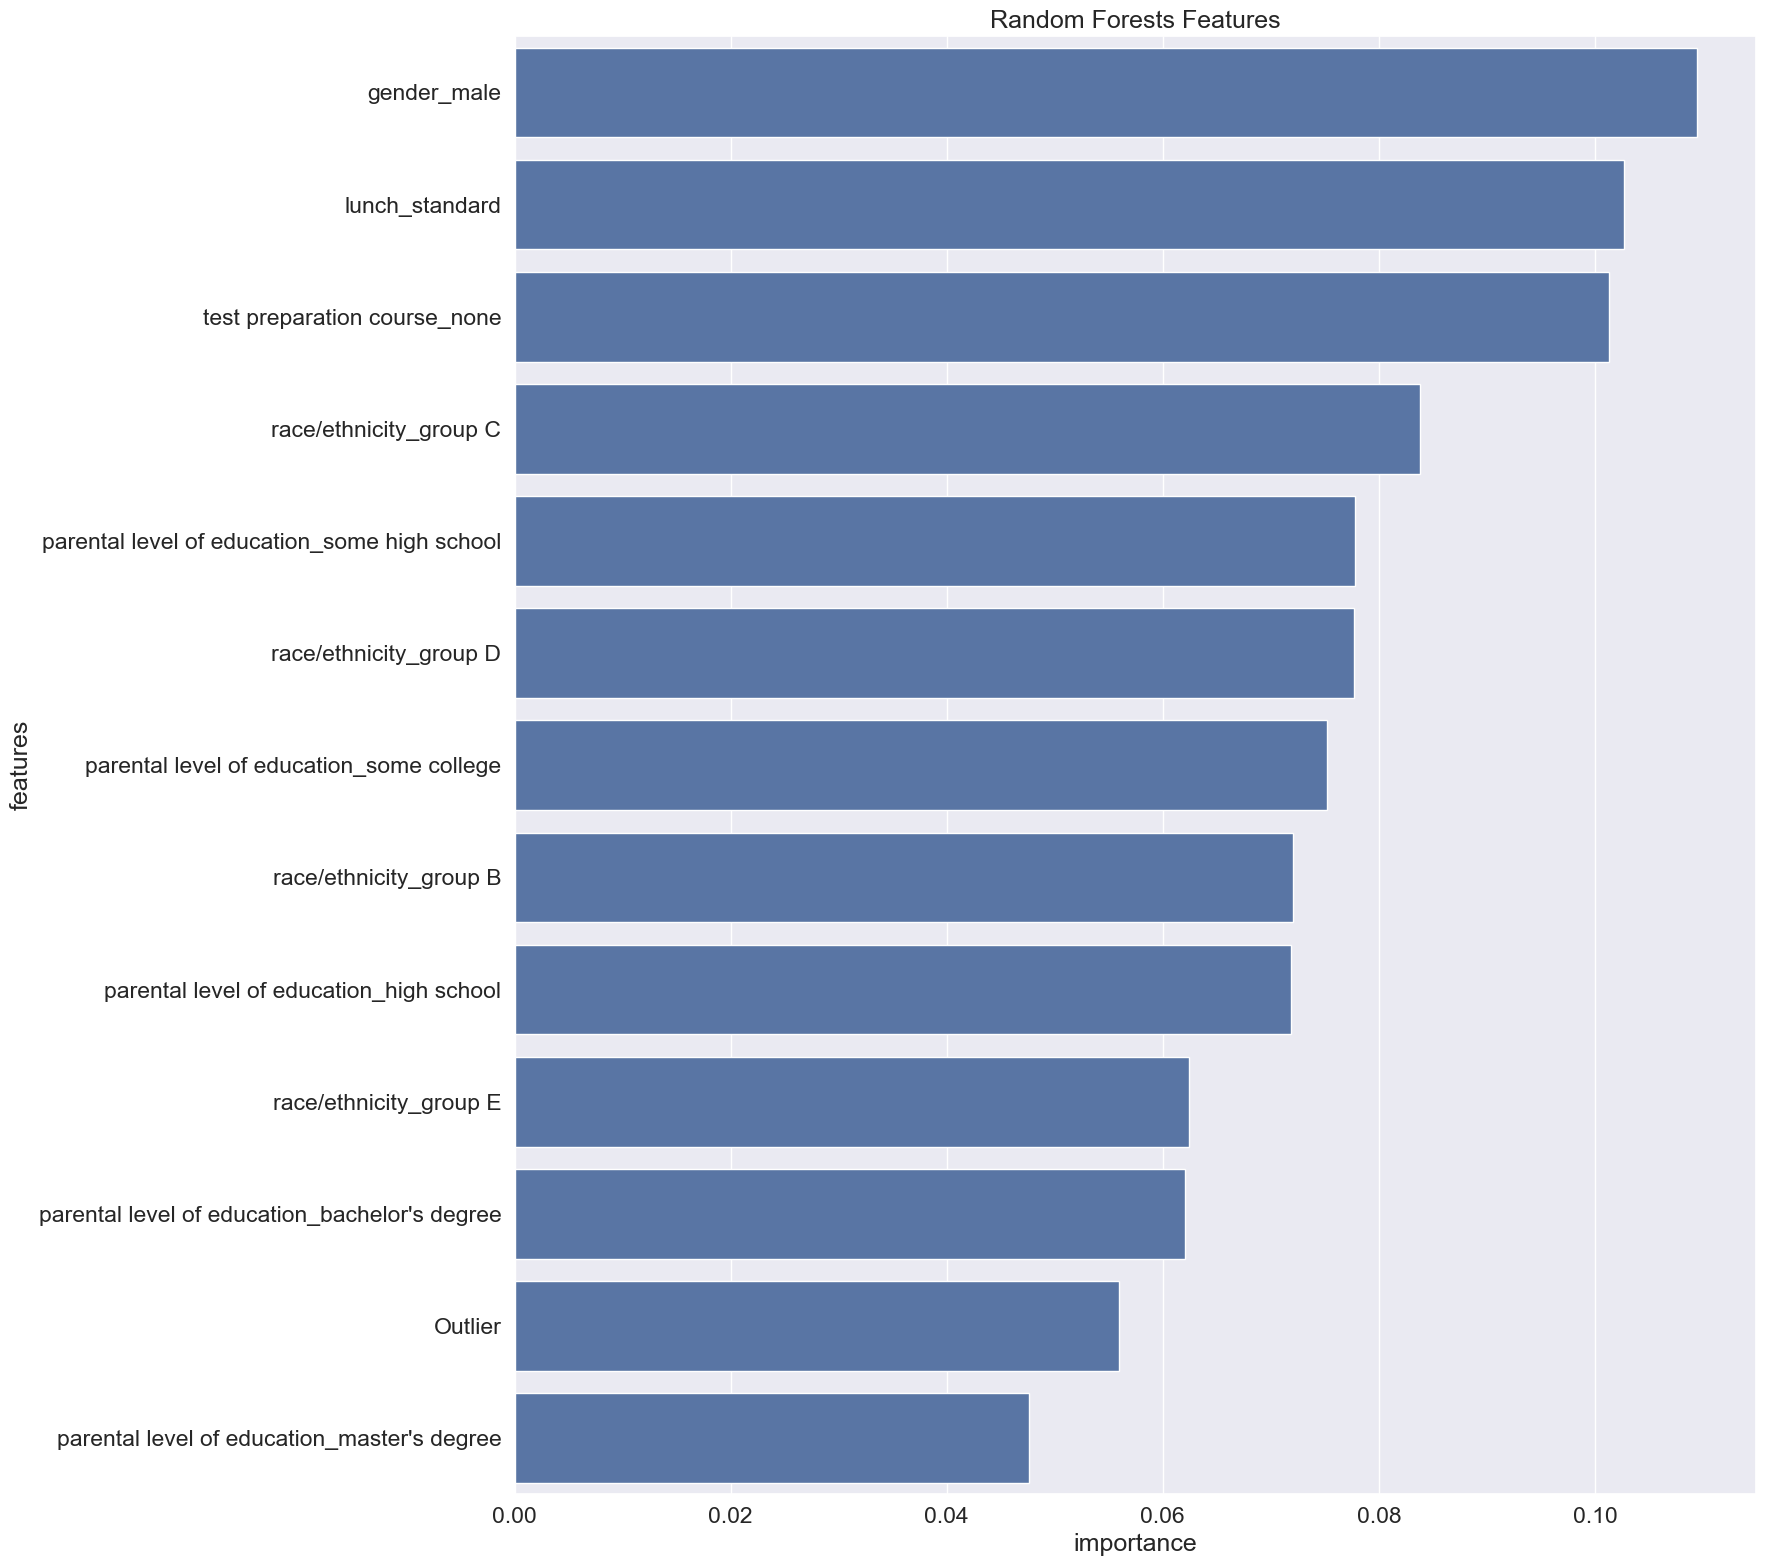

In [160]:
imp=feature_importances_df.sort_values(by="importance", ascending=False).head(30)
plt.figure(figsize=(18, 16))
sns.set(font_scale = 1.5)
sns.barplot(x="importance", y="features", data=imp.sort_values(by="importance", ascending=False))
plt.title('Random Forests Features')
plt.tight_layout()
plt.show()

# KNN

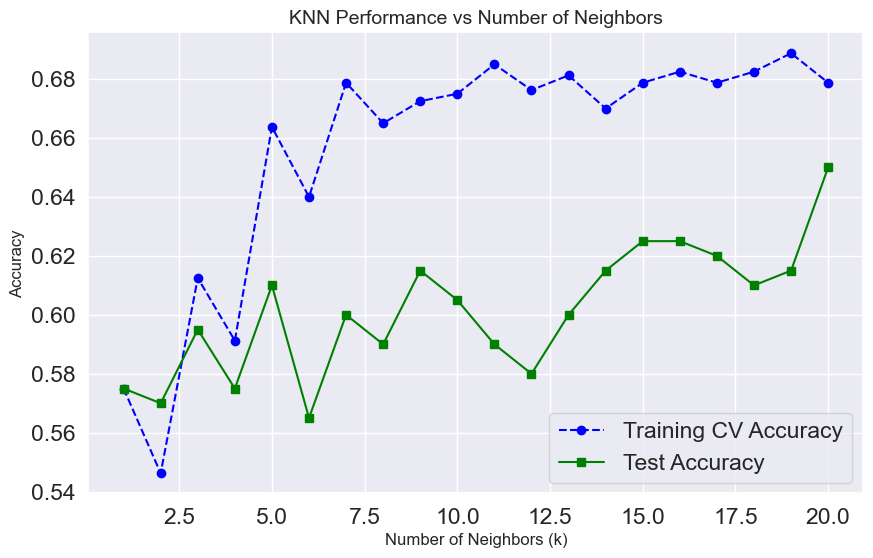

In [162]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Ensure y_train_single and y_test_single are binary or single-column
train_scores = []
test_scores = []

# Loop over different values for n_neighbors
for i in range(1, 21):  # n_neighbors from 1 to 20
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    
    # Cross-validation score for training data
    cv_score = cross_val_score(knn, X_train, y_train_single, cv=5).mean()
    train_scores.append(cv_score)
    
    # Fit the model and evaluate on the test set
    knn.fit(X_train, y_train_single)
    test_accuracy = accuracy_score(y_test_single, knn.predict(X_test))
    test_scores.append(test_accuracy)

# Plot the training and testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores, label="Training CV Accuracy", marker='o', linestyle='--', color='blue')
plt.plot(range(1, 21), test_scores, label="Test Accuracy", marker='s', linestyle='-', color='green')
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("KNN Performance vs Number of Neighbors", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
  

In [165]:
# Evaluate the KNN model's accuracy on the test set
knn_test_score = knn.score(X_test, y_test_single)  # Ensure y_test_single is properly defined
print("KNN Test Set Accuracy:", knn_test_score)


KNN Test Set Accuracy: 0.65


In [166]:
from sklearn.metrics import classification_report

# Generate predictions using the KNN model
ypred = knn.predict(X_test)

# Print the classification report
print("Classification Report for KNN:")
print(classification_report(ypred, y_test_single))  # Ensure y_test_single is correctly formatted


Classification Report for KNN:
              precision    recall  f1-score   support

       False       0.28      0.55      0.38        38
        True       0.87      0.67      0.76       162

    accuracy                           0.65       200
   macro avg       0.57      0.61      0.57       200
weighted avg       0.75      0.65      0.68       200



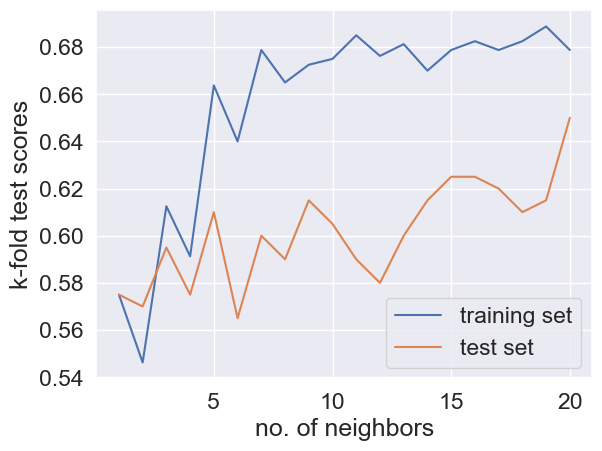

In [163]:
plt.plot(range(1,21,1),train_scores,label='training set')
plt.plot(range(1,21,1),test_scores,label='test set')
plt.xlabel('no. of neighbors')
plt.ylabel('k-fold test scores')
plt.legend()
plt.show()

In [168]:
train_scores

[0.575,
 0.54625,
 0.6125,
 0.59125,
 0.66375,
 0.6399999999999999,
 0.67875,
 0.6649999999999999,
 0.6725,
 0.675,
 0.6849999999999999,
 0.6762500000000001,
 0.68125,
 0.6699999999999999,
 0.67875,
 0.6825,
 0.67875,
 0.6825,
 0.68875,
 0.6787500000000001]

In [169]:
test_scores

[0.575,
 0.57,
 0.595,
 0.575,
 0.61,
 0.565,
 0.6,
 0.59,
 0.615,
 0.605,
 0.59,
 0.58,
 0.6,
 0.615,
 0.625,
 0.625,
 0.62,
 0.61,
 0.615,
 0.65]

20-NN is the best model

     Model  Accuracy  Precision  Recall  F1-Score
0  Model A      0.85       0.82    0.84      0.83
1  Model B      0.88       0.86    0.89      0.87
2  Model C      0.83       0.80    0.81      0.80


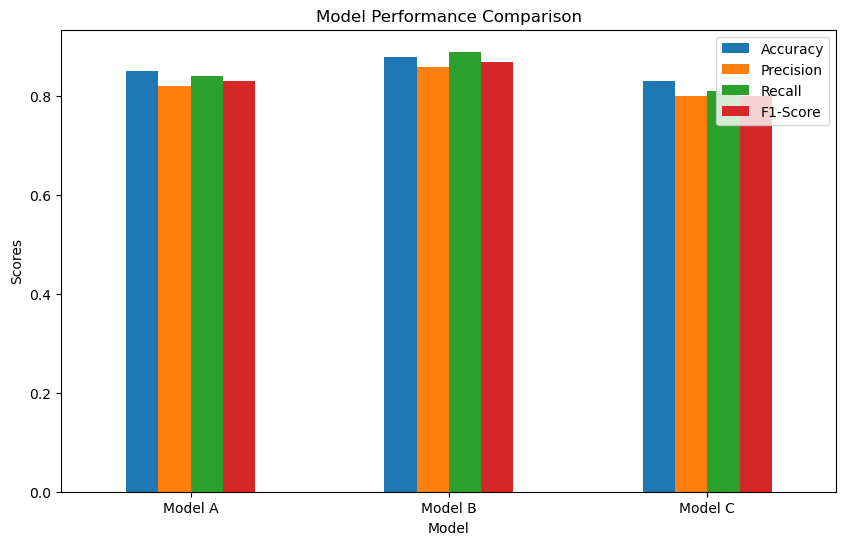

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data: Replace this with your actual results
data = {
    'Model': ['Model A', 'Model B', 'Model C'],
    'Accuracy': [0.85, 0.88, 0.83],
    'Precision': [0.82, 0.86, 0.80],
    'Recall': [0.84, 0.89, 0.81],
    'F1-Score': [0.83, 0.87, 0.80],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Plotting the comparison
df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.show()


# Key Findings


**Data Complexity:

Preprocessing steps, such as encoding categorical variables and scaling numeric features, addressed data challenges like inconsistencies and class imbalance.

**Bivariate Analysis:

Understanding relationships between variables helped in guiding feature selection and improving model predictions.
Model Performances:

**Logistic Regression:

Simple and efficient, achieving ~65% test accuracy, ideal for datasets with linear relationships.

**Decision Tree:

Balanced performance with a test accuracy of ~67.5% when max_depth=4.

**Random Forest: 

Highlighted important features but had slight overfitting with ~63.5% test accuracy.

**KNN:

Performed best with n_neighbors=20, achieving ~65% test accuracy, but sensitive to scaling.

**AdaBoost: 

The best model, achieving ~70.6% cross-validation accuracy, effectively handling class imbalance.

**PCA:

PCA was unnecessary, as the dataset’s issues were not related to dimensionality but rather data inconsistency and class imbalance.

**Recommendation:

AdaBoost is the most effective model for this dataset.
Improving data quality and handling class imbalance can further enhance model accuracy.
Feature importance insights are valuable for refining future datasets and improving predictions.

# 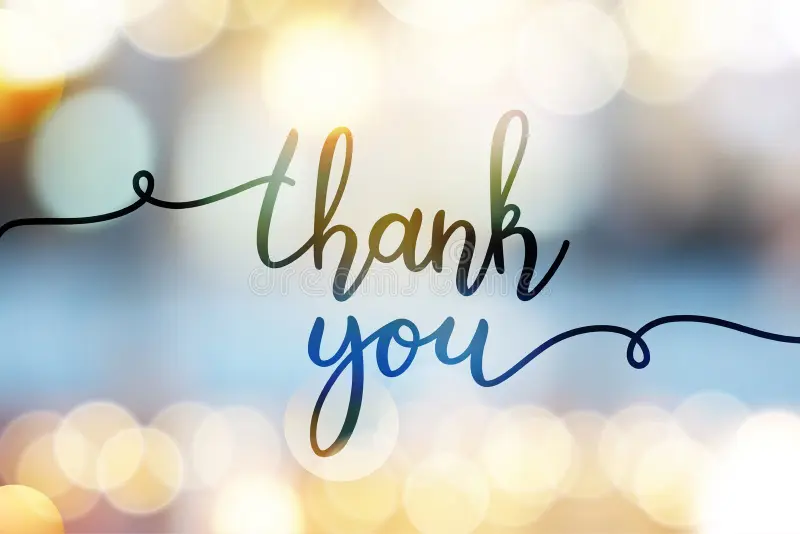